# IMT2118 - Tarea 3: Clustering y Regionalización.


## Atlas de Determinantes Sociales de la Salud , EEUU.


### Aspectos generales.

- Fecha de entrega: 15 de octubre 2020, 23:59.

- Formato de entrega: carpeta comprimida (.zip) incluyendo Jupyter Notebook con el desarrollo (puede utilizar este mismo notebook), y las capas o archivos vectoriales que haya generado como parte de su análisis. El objetivo es que el Notebook pueda correr completamente dentro de la carpeta entregada. En el Notebook, incluya texto explicando los pasos u operaciones desarrolladas, no sólo el código.

- Vía de entrega: a través de Canvas, correo electrónico con archivo adjunto o link para descarga (enviar a la profesora cc. al ayudante del curso).

- La Tarea debe ser desarrollada en lenguaje de programación Python. 

- Se sugiere hacer consultas y comentarios sobre la Tarea a traves del Foro del curso creado en Google Groups.


### Introducción. 

Los Determinantes Sociales de la Salud (DSS) son aquellas condiciones en los lugares donde las personas viven, aprenden, trabajan y juegan, que afectan a un amplio rango de riesgos y resultados de salud. Aunque se ha demostrado ampliamente que indicadores como pobreza y educación tiene impacto sobre la salud de las personas, no es tan claro por qué en algunos lugares el impacto es mayor que en otros.

El estudio "Atlas de Determinantes Sociales de la Salud" de EEUU analizó un conjunto de 15 indicadores comunes de DSS, que se agrupan en cuatro dimensiones. Luego estos indicadores pueden ser utilizados para identificar tipos de "vecindarios" de DSS. Los detalles del estudio y del dataset asociado están disponibles en los siguientes links:

https://sdohatlas.github.io/

https://geodacenter.github.io/data-and-lab//us-sdoh/

https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2759757

### Objetivo.

El objetivo de esta Tarea es identificar categorías o tipos de "vecindarios" de determinantes sociales de la salud. Es decir, conjuntos de zonas censales (no necesariamente conectadas espacialmente) que se caractericen por tener un perfil de DSS común, y por lo tanto podría esperarse tengan también indicadores de salud similares.


### Datos.

Los datos del Atlas pueden ser descargados en el siguiente link:

https://geodacenter.github.io/data-and-lab//us-sdoh/

El detalle de los campos de datos para cada zona censal (census track) está resumido en la siguiente tabla:

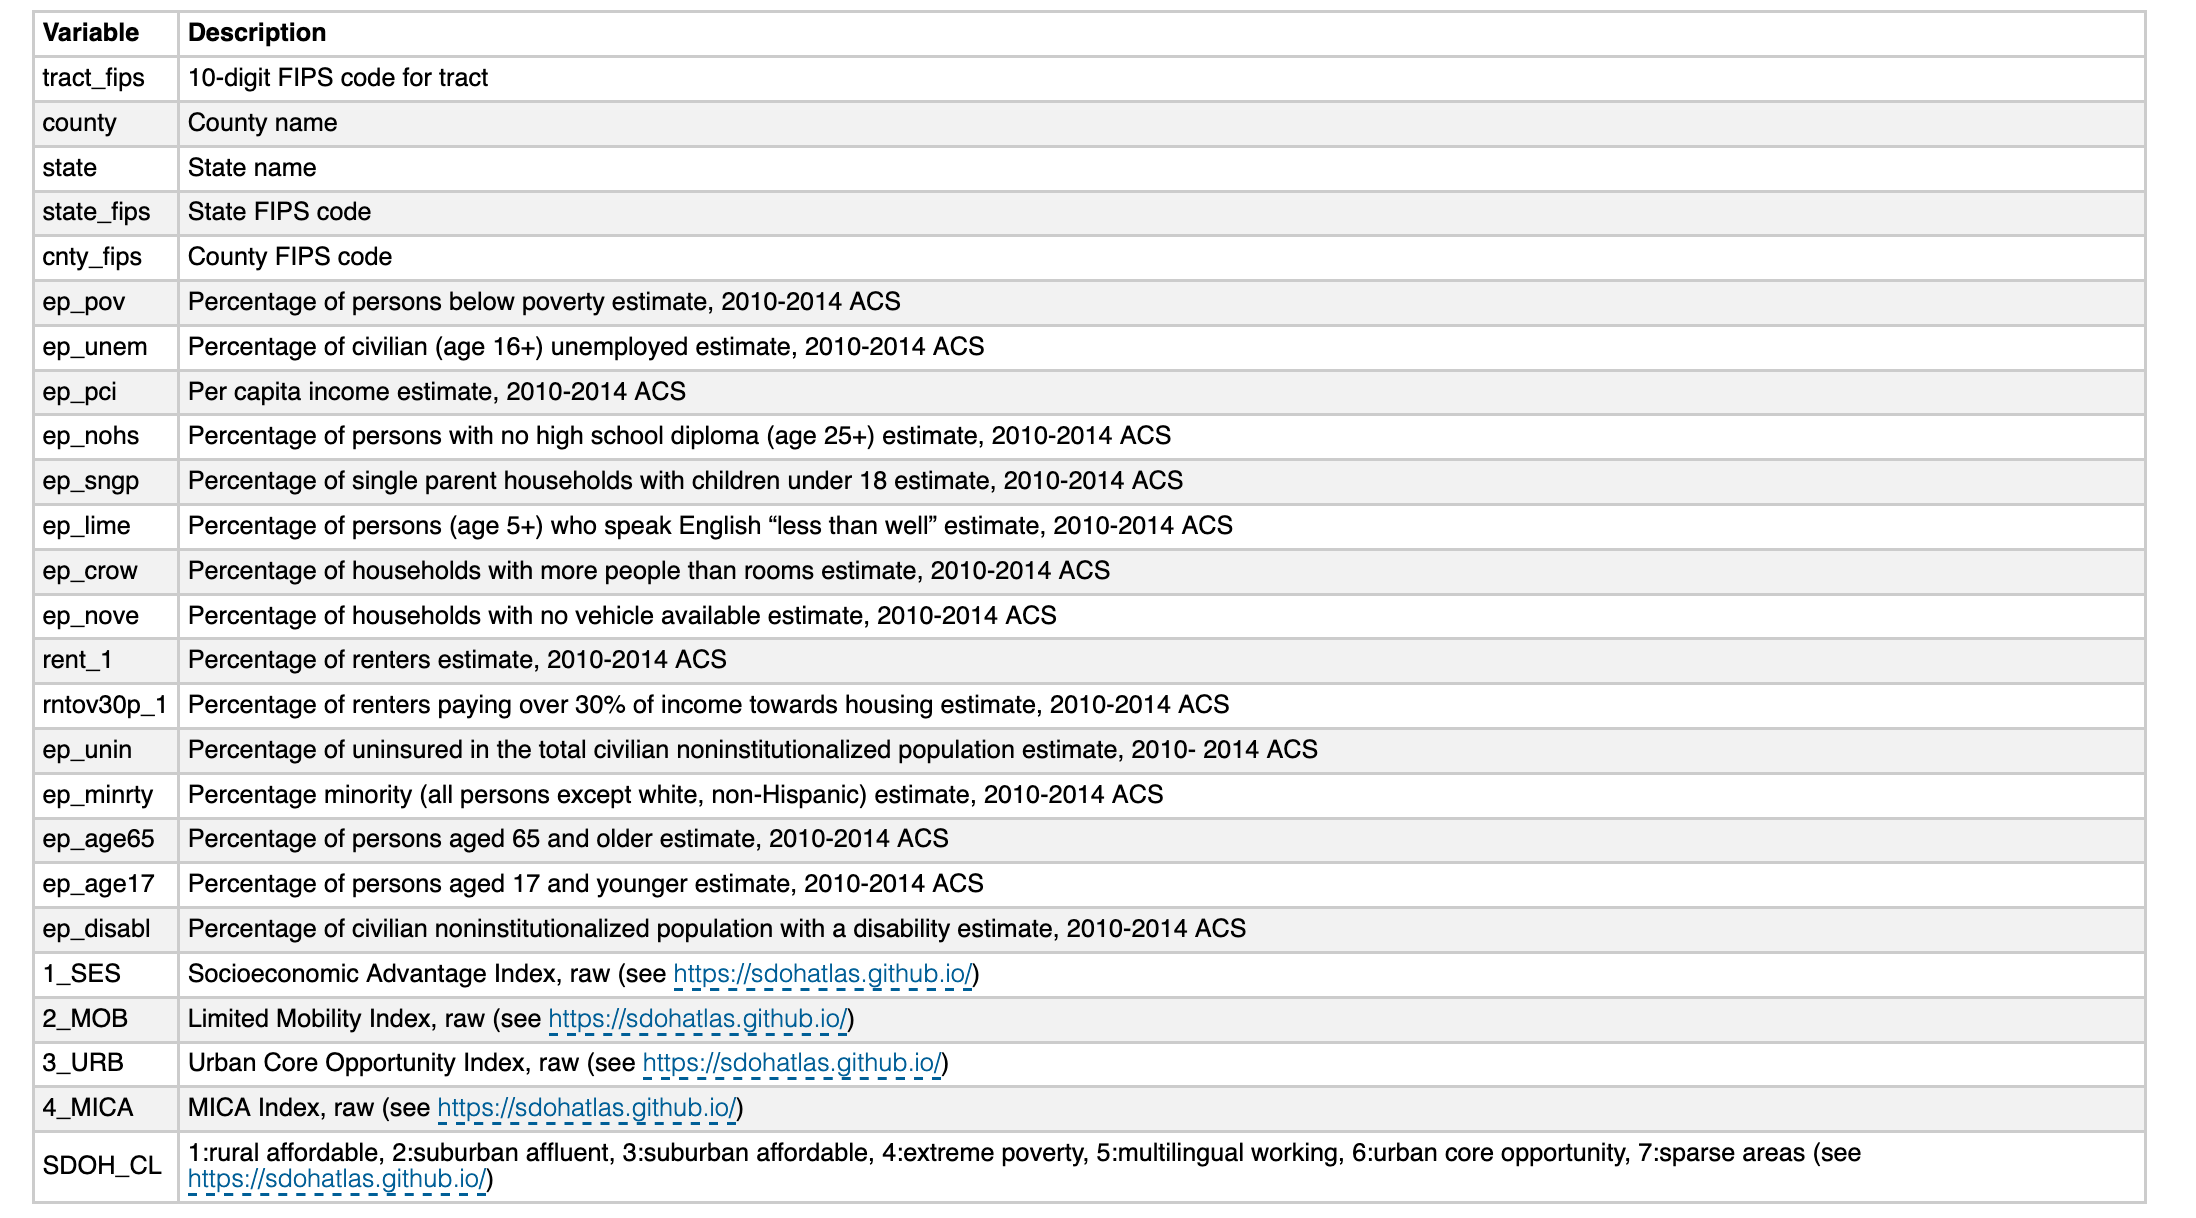


### Desarrollo.

#### 1. Análisis de autocorrelación espacial.

Analicemos primero sólo una de las dimensiones de los DSS, el Índice de Ventaja Socioeconómica (SES). ¿Existe algún patrón de autocorrelación espacial para este indicador en el territorio de EEUU?

**a)** Genere un gráfico de Moran, y calcule el Índice Global I para el SES con su nivel de significancia estadística. Puede usar cualquier matriz de pesos espaciales, pero justifique su elección y los parámetros utlizados en el cálculo de dicha matriz. 

**b)** En base al análisis de punto a), responda: ¿Existe algún patrón de autocorrelación espacial para el SES en el territorio de EEUU?

**c)** Si su respuesta anterior es afirmativa, identifique las zonas "calientes" (HH) y "frías" (LL) y los outliers del patrón espacial. ¿Qué representa cualitativamente cada una de estas áreas?

#### 2. Análisis de componentes principales.

La base de datos de DSS considera un total de 15 variables socioeconómicas que pueden tener un impacto relevante sobre las condiciones de salud de la población. Aplicando el método de PCA, determine:

**a)** ¿A cuántas dimensiones es posible reducir el análisis de DSS, y cuáles son las variables más relevantes? Justifique.

**b)** Identifique y genere un conjunto de componentes principales que expliquen adecuadamente la varianza de las 15 variables originales.

#### 3. Clustering e identificación de "vecindarios" de DSS.

Utilizando el set de componentes principales derivados en el punto anterior, aplique algún método de clustering para identificar tipologías o clases de zonas censales que comparten un perfil de DSS.

**a)** ¿En cuántos clusters o clases es recomendable agrupar las zonas censales de EEUU a partir de sus DSS? Justifique cuantitativamente su elección de `nclusters`.

**b)** Aplique alguno de los algoritmos de clustering vistos en clase y ayudantía, y determine una clasificación o agrupación de zonas censales en base a sus DSSs. 

**c)** Genere un mapa para visualizar la distribución espacial de las clases identificadas, y analice el perfil de DSS asociado a cada una de ellas. ¿Cómo podría describir o caracterizar cada una de las clases? ¿Son consistentes sus resultados con los del SDOH Atlas? Justifique su respuesta. 


In [110]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import pysal as ps
from pysal.lib import weights
from pysal.explore import esda
from shapely.geometry import Polygon, Point
from splot.esda import moran_scatterplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

import warnings

# Ignoramos Warnings de Python
warnings.filterwarnings("ignore")

In [111]:
# Cargamos datos 

usa = gpd.read_file("data/us-sdoh-2014.shp").to_crs(crs = 'EPSG:3857')

## Análisis pregunta 1

In [112]:
# Obtenemos las columnas de nuestro interés

SES = usa[['1_SES', 'geometry']].copy()
SES = SES.rename(columns={'1_SES': 'SES'})

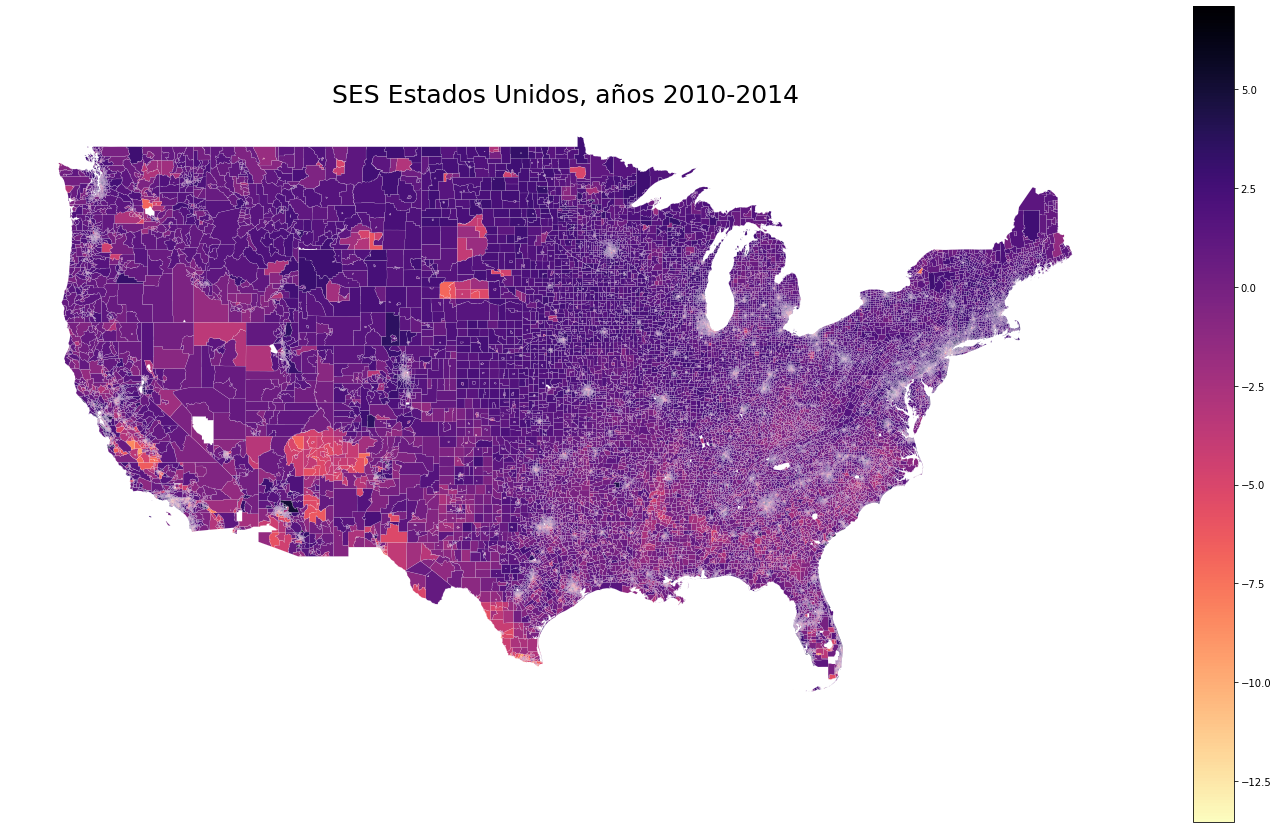

In [113]:
# Efectuamos una visualización preliminar

variable = 'SES'

fig, ax = plt.subplots(1, figsize=(25, 15))
SES.plot(ax=ax, column=variable, cmap='magma_r', k= 10, edgecolor='w', lw = 0.1, legend = True)
ax.set_title('SES Estados Unidos, años 2010-2014', fontdict={'fontsize': 25, 'fontweight' :  30, 'color': 'black'})
ax.axis('off')
plt.show()

In [114]:
# Creamos columna SES normalizada

mean = np.mean(SES['SES'])
std = np.std(SES['SES'])
SES['SES_norm'] = (SES['SES'] - mean)/std

In [115]:
# Añadimos columna de índices

SES = SES.reset_index()

In [116]:
# Utilizamos matriz Knn Weights y la normalizamos

qw = weights.KNN.from_dataframe(SES, k=3, ids='index')
qw.transform = 'R'

In [117]:
# Obtenemos el lag espacial y lo agregamos como columna al df SES

qw_lag = pd.Series(weights.lag_spatial(qw, SES['SES_norm']), index = SES.index)
SES['SES_queen_lag'] = qw_lag

Generaremos e, gráfico de Moran. Escogí como matriz de pesos la de KNN. Esta elección la hice considerando que de esta manera disminuía la cantidad de islas en la matriz con lo cual se facilitaba e trabajo para poder hacer el gráfico de LISA.

Text(0.5, -4, 'I Moran:0.73, p_sim:0.0010')

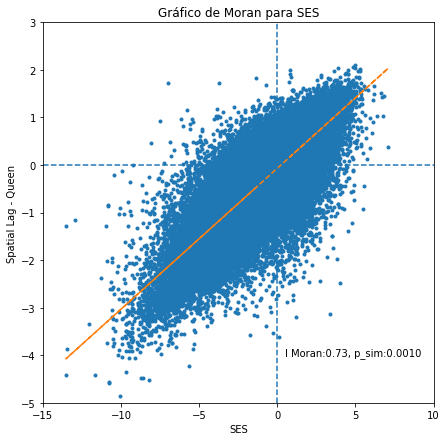

In [118]:
fig, ax = plt.subplots(1, figsize=(7, 7))

x = SES['SES']
y = SES['SES_queen_lag']
m, b = np.polyfit(x, y, 1)
ax.plot(x, y, '.')
ax.plot(x, m * x + b, ls = '--')
ax.set_xlabel('SES')
ax.set_ylabel('Spatial Lag - Queen')
ax.set_xlim(-15, 10)
ax.set_ylim(-5,3)
ax.set_title('Gráfico de Moran para SES')
ax.axhline(y=0,ls='--')
ax.axvline(x=0,ls='--')

moran = esda.Moran(x, qw)
ax.text(0.5, -4,'I Moran:%.2f, p_sim:%.4f'%(moran.I, moran.p_sim))


Notamos que el valor-p del estadístico de Moran es menor que 0.05, por lo tanto el test es estadísticamente significativo, es decir, se puede rechazar la hipótesis nula con lo cual se concluye que la distribución espacial de los valores altos y los valores bajos en el dataset está más agrupada espacialmente de lo que se esperaría si los procesos espaciales subyacentes fueran aleatorios.

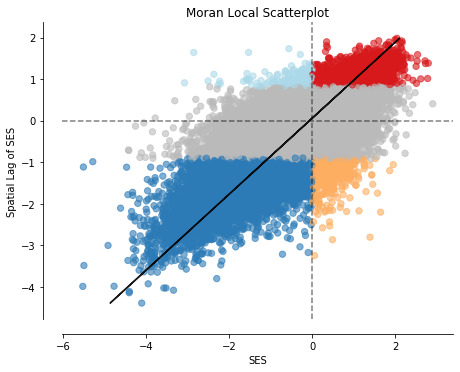

In [119]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_loc = Moran_Local(x, qw)
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('SES')
ax.set_ylabel('Spatial Lag of SES')
plt.show()

Ahora bien, efectuamos el gráfico de LISA con el cual podemos observar las zonas HH, HL, LH, LL.En términos generales, estas zonas representan lo siguiente:


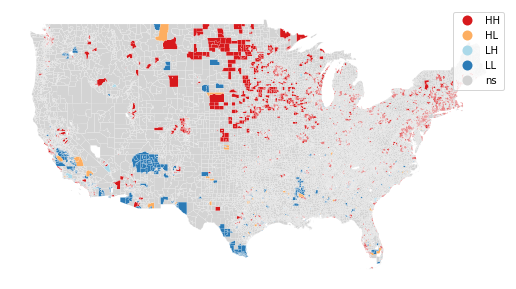

In [120]:
from splot.esda import lisa_cluster

lisa_cluster(moran_loc, SES, p=0.05, figsize = (9,9))
plt.show()

#### HH (Rojo): valores SES sobre el promedio rodeados por valores SES sobre el promedio.
#### LL (Azul): valores SES bajo el promedio rodeados por valores SES bajo el promedio.
#### HL (Amarillo): Valores SES sobre el promedio rodeados de valores SES más bajos del promedio.
#### LH (Celeste): Valores SES bajo el promedio rodeados de valores SES sobre el promedio.

## Análisis pregunta 2

In [121]:
# Definimos lista de posibles variables útiles

columns = usa.columns[5:-1]

In [122]:
# Normalizamos columnas

scaler = StandardScaler()
usa_std = scaler.fit_transform(usa[columns])

In [123]:
pca = PCA() 
pca.fit(usa_std)
print(pca.components_.shape)


(20, 20)


In [124]:
pca.explained_variance_ratio_

array([3.59309762e-01, 1.50262111e-01, 1.35142761e-01, 1.10747400e-01,
       4.68256438e-02, 3.53527926e-02, 2.89669042e-02, 2.45268254e-02,
       2.04639173e-02, 1.74222906e-02, 1.71179446e-02, 1.29651782e-02,
       1.25629868e-02, 1.11256185e-02, 1.01444318e-02, 7.06343264e-03,
       1.88237230e-17, 1.70160772e-17, 1.38836859e-17, 5.99282208e-18])

Text(0, 0.5, 'Varianza explicada acumulada')

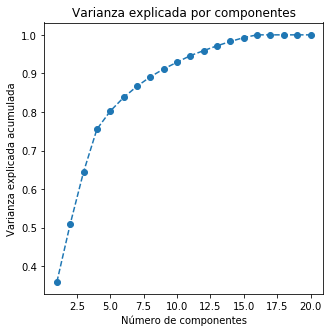

In [125]:
# Generamos gráfico de varianza explicada por componentes

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(range(1,21), pca.explained_variance_ratio_.cumsum(),marker='o',ls='--')
ax.set_title('Varianza explicada por componentes')
ax.set_xlabel('Número de componentes')
ax.set_ylabel('Varianza explicada acumulada')

Podemos observar que con 5 variables se obtiene una ganancia aproximada del 80% de la varianza. Así, utilizamos dicha cantidad de componentes principales.

In [126]:
pca = PCA(n_components = 5)
pca.fit(usa_std)

PCA(n_components=5)

In [127]:
# Obtenemos columnas de máxima importancia para cada componente

pca_columns = []

n_components = 5
n_vars = 19
for n_row in range(n_components):
    max_abs = abs(pca.components_[n_row,:]).max()
    for j in range(20):
        if abs(pca.components_[n_row, j]) == max_abs:
            pca_columns.append(j)

In [128]:
# Las columnas correspondientes se encuentran trasladadas en 5 unidades puesto que no consideramos a las
# Primeras 5 columnas como variables posibles.

for index in pca_columns:
    print(usa.columns[index + 5])

1_SES
2_MOB
3_URB
4_MICA
rntov30p_1


Es decir, las variables de mayor importancia para cada una de las componentes principales son:
    
#### Socioeconomic Advantage Index
#### Limited Mobility Index
#### Urban Core Opportunity Index
#### MICA Index
#### Percentage of renters paying over 30% of income Towards housing estimate 2010-2014 ACS

In [129]:
# Obtenemos tabla de pca columns
usa_pca = pca.transform(usa_std)

In [130]:
# Agregamos dichas columnas al df original

for i in range(5):
    usa[f'C{i + 1}'] = usa_pca[:,i]

Consideramos entonces el dataframe con dichas variables

# Análisis pregunta 3

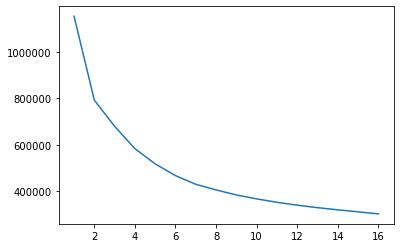

In [131]:
# Aplicaremos método del codo

n_cl = 17
np.random.seed(1234)

inercia = []

for n in range(1, n_cl):
    kmeans = KMeans(n_clusters = n)
    cls_kmeans = kmeans.fit(usa_pca)
    inercia.append(cls_kmeans.inertia_)

    
x = [i for i in range(1, n_cl)]
plt.plot(x, inercia)

#### Existen dos quiebres notorios en el gráfico, sin embargo el momento en el que se vuelve realmente menos significativa la pérdida de pendiente de la cirva es para un número de 7 clusters. Sin embargo, ocuparemos 6 clusters teniendo en cuenta una pequeña penalización al observar un quiebre pronunciado más a la izquierda del gráfico (para el punto correspondiente a 2 clusters).

In [132]:
kmeans = KMeans(n_clusters = 5)
cls_kmeans = kmeans.fit(usa_pca)

Text(0.5, 1, 'Gráfico demográfico 6 clusters')

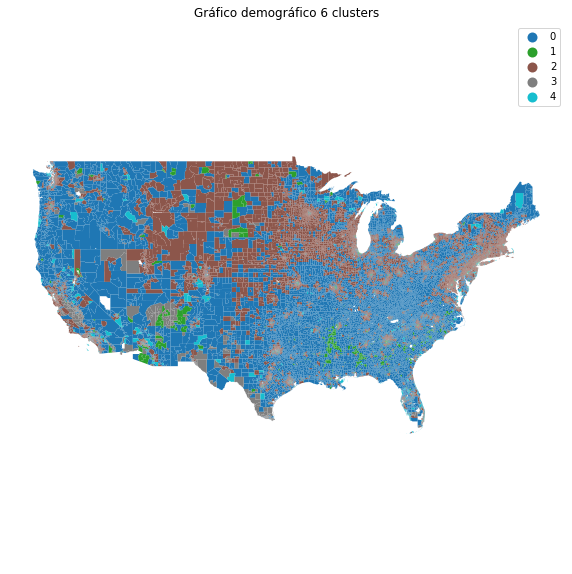

In [133]:
# Asignar etiquetas de clustering a una columna

fig, ax = plt.subplots(1, figsize=(10, 10))

usa['etiqueta'] = cls_kmeans.labels_
usa.plot(column = 'etiqueta', categorical = True, legend = True, linewidth = 0, ax=ax)
ax.set_axis_off()
plt.axis('equal')
ax.set_title('Gráfico demográfico 6 clusters')

### Mostramos los promedios por clusters para cada variable

In [134]:
usa.groupby('etiqueta').mean()[columns].T

etiqueta,0,1,2,3,4
ep_pov,17.533998,37.432558,7.032404,27.008597,16.789253
ep_unem,10.250118,19.618617,6.252497,12.143641,8.341356
ep_pci,22561.284635,15214.521701,38016.266144,16530.688646,39626.773629
ep_nohs,15.465346,23.346325,6.290463,35.579253,9.366095
ep_sngp,9.788334,20.098831,6.618201,15.484567,4.341036
ep_lime,2.209333,4.301965,1.822796,21.113585,4.379667
ep_crow,2.444568,4.598868,1.378018,15.298096,2.518618
ep_nove,6.881554,26.137632,3.594472,14.878670,21.267205
rent_1,30.904679,61.924636,22.999291,54.860736,54.812815
rntov30p_1,13.131374,21.324549,13.921732,16.467202,23.521493


In [135]:
usa['1_SES'].describe()

count    7.190100e+04
mean     1.335169e-10
std      2.449407e+00
min     -1.352792e+01
25%     -1.276994e+00
50%      5.969066e-01
75%      1.781273e+00
max      7.095238e+00
Name: 1_SES, dtype: float64

In [136]:
usa['2_MOB'].describe()

count    7.190100e+04
mean     7.649407e-11
std      1.416020e+00
min     -1.305663e+01
25%     -8.220167e-01
50%      6.050500e-02
75%      9.187714e-01
max      6.321907e+00
Name: 2_MOB, dtype: float64

In [137]:
usa['3_URB'].describe()

count    7.190100e+04
mean     8.901128e-11
std      1.202808e+00
min     -5.644709e+00
25%     -8.018593e-01
50%     -2.315558e-01
75%      5.393176e-01
max      9.399401e+00
Name: 3_URB, dtype: float64

In [138]:
usa['4_MICA'].describe()

count    7.190100e+04
mean     8.066647e-11
std      1.101675e+00
min     -9.817540e+00
25%     -5.527549e-01
50%      2.786980e-02
75%      6.026452e-01
max      7.990794e+00
Name: 4_MICA, dtype: float64

In [139]:
usa['rntov30p_1'].describe()

count    71901.000000
mean        15.527848
std         12.034755
min          0.000000
25%          7.600000
50%         13.400000
75%         20.900000
max        100.000000
Name: rntov30p_1, dtype: float64

### Descripción de clusters:

#### Cluster 0: Posee valores cercanos al promedio en cada una de las variables más significativas.

#### Cluster 1: Posee un SES bajo, MOB bajo y un MICA sobre el promedio. Es decir, este corresponde a un cluster con una desventaja económica, mobilidad reducida (se espera una mayor población de adulto mayor) y que además posee una baja caracterización de inmigrantes.

#### Cluster 2: SES Sobre el promedio y MOB sobre el promedio. Este es un cluster caracterizado por una buena situación socioeconómica y con una alta movilidad, probablemente asociada a un grupo de adultos jóvenes y niños.

#### Cluster 3: SES Bajo, MOB alto, MICA bajo. Corresponde a un cluster con desventaja socioeconómica, población relativamente jóven dadas sus ventajas de movilidad y que además posee una tasa de inmigrantes sobre el promedio aunque no en una cantidad exagerada.

#### Cluster 4: MOB bajo, URB alto, rntov alto. Corresponde a un grupo de cualidades socioeconómicas promedio caracterizada por poseer una mayor cantidad de adultos mayores que viven en lugares con muy buena accesibilidad y economía consolidada que se ve reflejada en el pago de sus arriendos que tiende a ser sobre el promedio


Como ya especifiqué en la parte superior qué representa cada cluster, ahora me referiré a ellos de esa forma para resumir la información.

Los clusters tienden a calzar bastante bien con el estudio adjunto en la tarea. Por ejemplo, al cluster 2 tiende a concentrarse en la zona centro-norte de Estados Unidos. El cluster 4 se tiende a concentrar en zonas pequeñas muy específicas relativamente esparcidas. El cluster 3 tiende a presentarse en la zona centro-poniente de Estados Unidos.